In [1]:
import praw
import pandas as pd
from datetime import datetime

# Reddit API credentials
reddit = praw.Reddit(
    client_id="jQHFBhEtqzPZvnhFu5alpw",
    client_secret="PQbvtneqGtMdAirmptWzYfd3X2TiSw",
    user_agent="mental_health_data_collector"
)

# Keywords and subreddits
keywords = ['depression', 'anxiety', 'therapy', 'mental health', 'stress', 'suicidal']
subreddits = ['mentalhealth', 'depression', 'anxiety', 'offmychest', 'therapy', 'SuicideWatch']

# Data collection
data = []

# Use search with time_filter and larger limits via ListingGenerator
for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    for keyword in keywords:
        try:
            for submission in subreddit.search(keyword, sort='new', time_filter='all', limit=None):
                data.append({
                    "post_id": submission.id,
                    "created_utc": datetime.utcfromtimestamp(submission.created_utc),
                    "title": submission.title,
                    "selftext": submission.selftext,
                    "subreddit": subreddit_name,
                    "score": submission.score,
                    "url": submission.url,
                    "keyword": keyword,
                    "author": str(submission.author) if submission.author else "deleted"
                })
        except Exception as e:
            print(f"Error on {subreddit_name} / {keyword}: {e}")

# Save to CSV
df = pd.DataFrame(data)
df.to_csv("mental_health_posts.csv", index=False)

print("Data collection complete. Total posts collected:", len(df))

Data collection complete. Total posts collected: 8823


In [2]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [3]:
def preprocess_text_nltk(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)

    # 3. Tokenize
    tokens = word_tokenize(text)

    # 4. Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # 5. Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [4]:
# Load your data
df = pd.read_csv('mental_health_posts.csv')

# Drop rows with missing or empty text
df = df.dropna(subset=['selftext'])
df = df[df['selftext'].str.strip() != '']

# Apply preprocessing
df['clean_text'] = df['selftext'].apply(preprocess_text_nltk)

In [5]:
df.to_csv('cleaned_posts_nltk.csv', index=False)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf = TfidfVectorizer(max_features=1000)  

# Fit and transform the clean text
tfidf_matrix = tfidf.fit_transform(df['clean_text'])

# Convert to DataFrame (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# Tokenize for Word2Vec
df['tokens'] = df['clean_text'].apply(lambda x: x.split())

# Train Word2Vec model
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Get average vector for each post
def get_avg_vector(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

df['w2v_vector'] = df['tokens'].apply(get_avg_vector)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embedding
def get_bert_embedding(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        outputs = bert(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply to first 100 posts
df['bert_vector'] = df['clean_text'][:100].apply(get_bert_embedding)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

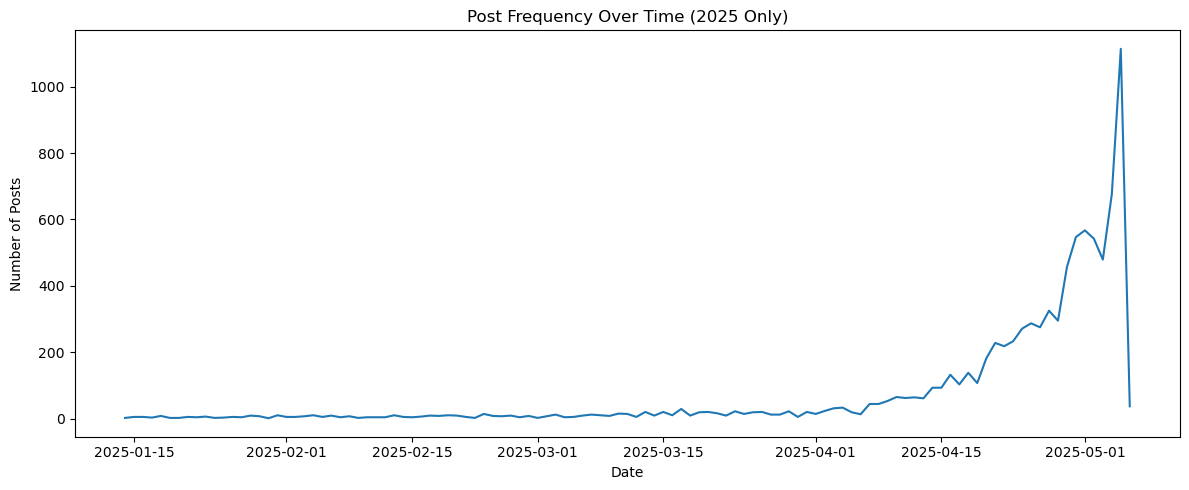

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime format
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Filter posts from year 2025
df_2025 = df[df['created_utc'].dt.year == 2025]

# Group by day
daily_counts_2025 = df_2025.groupby(df_2025['created_utc'].dt.date).size()

# Plot
plt.figure(figsize=(12, 5))
daily_counts_2025.plot()
plt.title("Post Frequency Over Time (2025 Only)")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

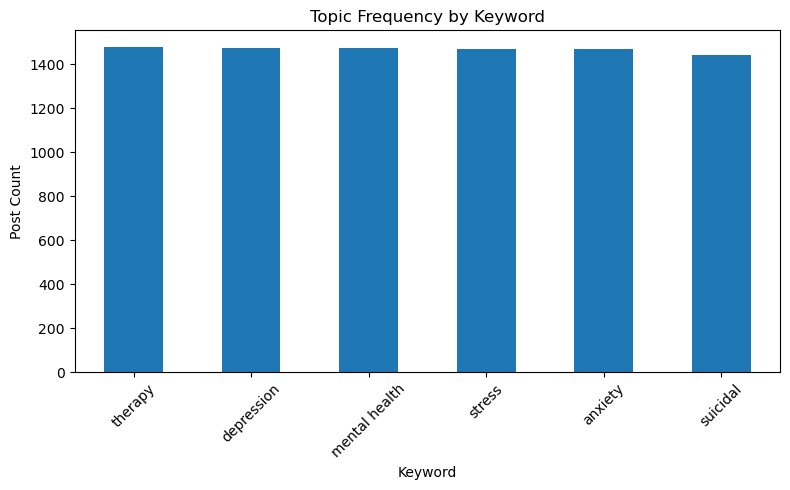

Total posts by keyword:
therapy          1481
depression       1473
mental health    1473
stress           1472
anxiety          1469
suicidal         1445
Name: keyword, dtype: int64
Grand Total Posts: 8813


In [11]:
import matplotlib.pyplot as plt

# Plot bar chart
plt.figure(figsize=(8, 5))
keyword_counts = df['keyword'].value_counts()
keyword_counts.plot(kind='bar')

# Add chart labels
plt.title("Topic Frequency by Keyword")
plt.xlabel("Keyword")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print total count
print("Total posts by keyword:")
print(keyword_counts)

print("Grand Total Posts:", keyword_counts.sum())

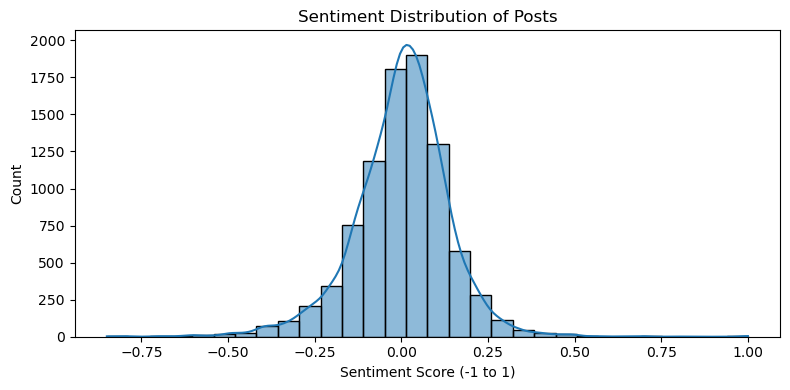

In [12]:
# Apply sentiment score
df['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title("Sentiment Distribution of Posts")
plt.xlabel("Sentiment Score (-1 to 1)")
plt.tight_layout()
plt.show()

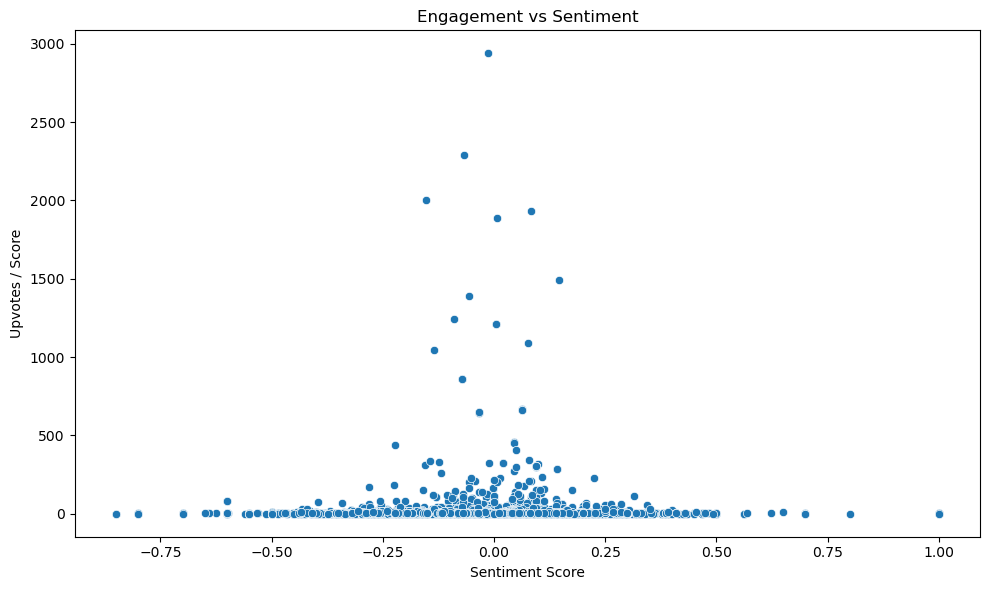

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment', y='score', data=df)
plt.title("Engagement vs Sentiment")
plt.xlabel("Sentiment Score")
plt.ylabel("Upvotes / Score")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import zscore

df['score_z'] = zscore(df['score'])
outliers = df[df['score_z'].abs() > 3] 

print("Number of outlier posts (high/low engagement):", len(outliers))

Number of outlier posts (high/low engagement): 48


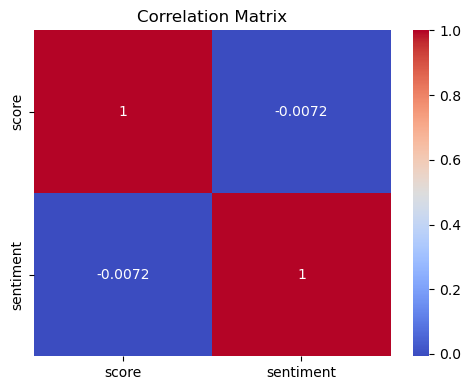

In [15]:
# Select numeric columns
numeric_cols = df[['score', 'sentiment']]

# Compute correlation matrix
correlation = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['clean_text'])

df['label'] = df['keyword'].apply(lambda x: 1 if x.lower() in ['depression', 'suicidal'] else 0)

# Target labels
y = df['label'] 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))

Confusion Matrix:
 [[1061  100]
 [ 373  229]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82      1161
           1       0.70      0.38      0.49       602

    accuracy                           0.73      1763
   macro avg       0.72      0.65      0.65      1763
weighted avg       0.72      0.73      0.71      1763

ROC-AUC Score: 0.7692546521643331


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['clean_text'])

# Labeling: 1 for 'depression' or 'suicidal', else 0
df['label'] = df['keyword'].apply(lambda x: 1 if x.lower() in ['depression', 'suicidal'] else 0)
y = df['label'] 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

Confusion Matrix:
 [[1009  152]
 [ 340  262]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.87      0.80      1161
           1       0.63      0.44      0.52       602

    accuracy                           0.72      1763
   macro avg       0.69      0.65      0.66      1763
weighted avg       0.71      0.72      0.71      1763

ROC-AUC Score: 0.6976343569096408


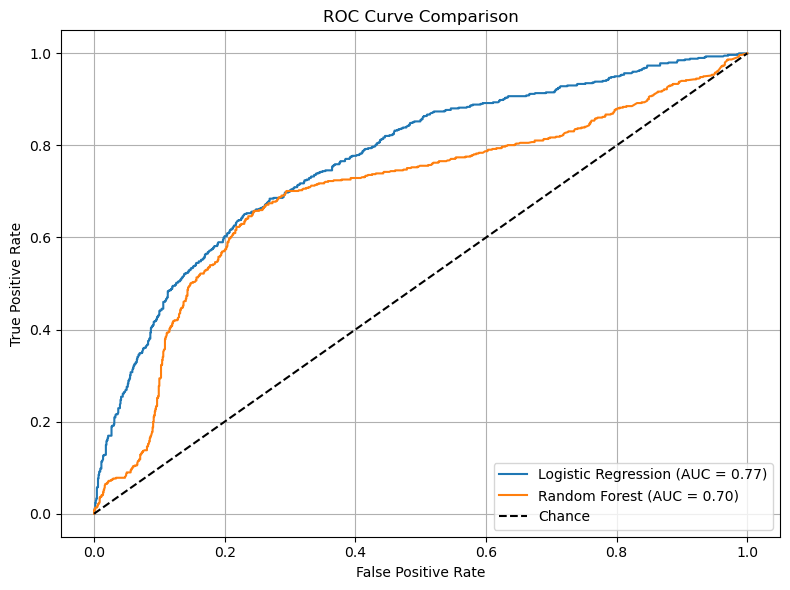

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve points
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_lr):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

metrics = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf)
    ]
}

# Create DataFrame for easy comparison
comparison_df = pd.DataFrame(metrics)
comparison_df.set_index("Model", inplace=True)
comparison_df = comparison_df.round(4)

# Print comparison
print("Model Comparison Summary")
print(comparison_df)

Model Comparison Summary
                     Precision  Recall  F1-Score  ROC-AUC
Model                                                    
Logistic Regression     0.6960  0.3804    0.4919   0.7693
Random Forest           0.6329  0.4352    0.5157   0.6976


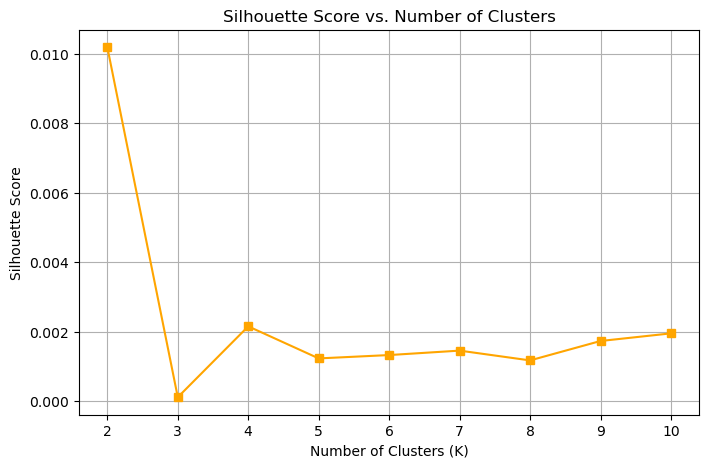

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

X_cluster = tfidf_matrix

# Define a range of cluster numbers to try
K = range(2, 11) 

silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_cluster)
    score = silhouette_score(X_cluster, labels)
    silhouette_scores.append(score)

# Plotting silhouette scores
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(list(K), silhouette_scores, marker='s', color='orange')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K = range(2, 11)
best_k = 0
best_score = -1

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_cluster)
    score = silhouette_score(X_cluster, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")
    
    if score > best_score:
        best_score = score
        best_k = k

print(f"\n Optimal number of clusters based on silhouette score: {best_k}")

K=2, Silhouette Score=0.0102
K=3, Silhouette Score=0.0001
K=4, Silhouette Score=0.0021
K=5, Silhouette Score=0.0012
K=6, Silhouette Score=0.0013
K=7, Silhouette Score=0.0015
K=8, Silhouette Score=0.0012
K=9, Silhouette Score=0.0017
K=10, Silhouette Score=0.0019

 Optimal number of clusters based on silhouette score: 2


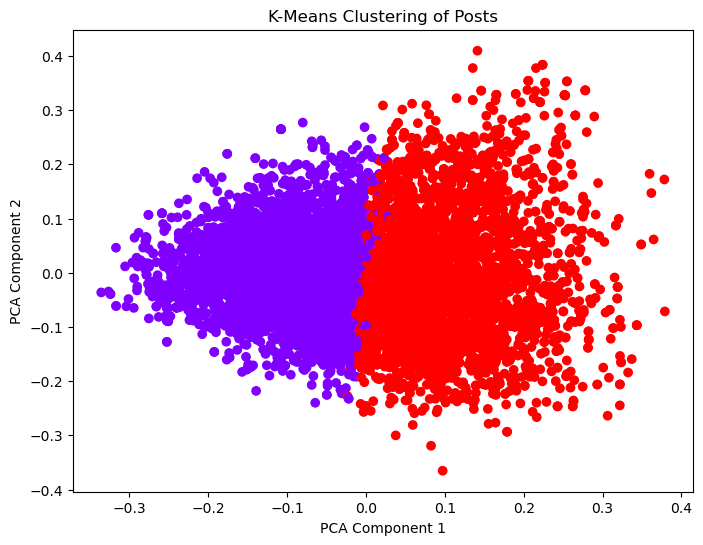

In [22]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use the same TF-IDF features from above
X_cluster = tfidf.fit_transform(df['clean_text'])

kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_cluster)

# Assign cluster labels
df['cluster'] = kmeans.labels_

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='rainbow')
plt.title("K-Means Clustering of Posts")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

Topics: 2, Perplexity: 873.64
Topics: 3, Perplexity: 1003.36
Topics: 4, Perplexity: 1107.71
Topics: 5, Perplexity: 1176.91
Topics: 6, Perplexity: 1248.91
Topics: 7, Perplexity: 1284.55
Topics: 8, Perplexity: 1339.58
Topics: 9, Perplexity: 1388.25
Topics: 10, Perplexity: 1381.54

Best number of topics based on lowest perplexity: 2


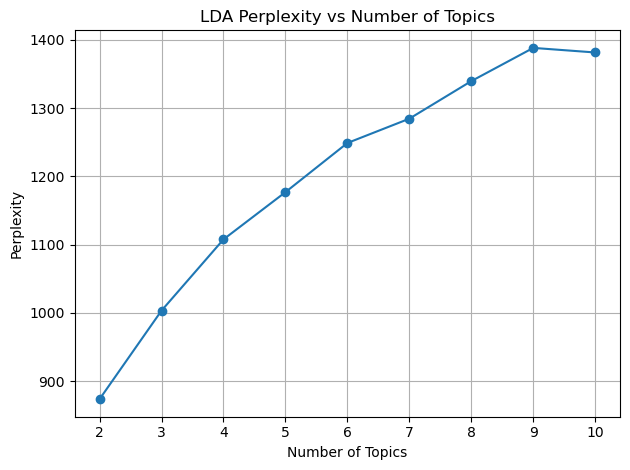

In [23]:
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

perplexities = []
topic_range = range(2, 11)

for k in topic_range:
    lda_model = LatentDirichletAllocation(n_components=k, random_state=42)
    lda_model.fit(X_cluster)
    perplexity = lda_model.perplexity(X_cluster)
    perplexities.append(perplexity)
    print(f"Topics: {k}, Perplexity: {perplexity:.2f}")

# Find topic count with lowest perplexity
best_count = topic_range[perplexities.index(min(perplexities))]
print(f"\nBest number of topics based on lowest perplexity: {best_count}")

# Plotting
plt.plot(topic_range, perplexities, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("LDA Perplexity vs Number of Topics")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Convert text to count matrix
count_vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X_count = count_vectorizer.fit_transform(df['clean_text'])

# Step 2: Fit LDA model with best_count
final_lda = LatentDirichletAllocation(n_components=best_count, random_state=42)
lda_topics = final_lda.fit_transform(X_count)

# Step 3: Assign dominant topic to each post
df['lda_topic'] = lda_topics.argmax(axis=1)

# Step 4: Print top words for each topic
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_features)}")

print("\nTop Words per Topic:")
print_top_words(final_lda, count_vectorizer.get_feature_names_out())


Top Words per Topic:
Topic #1: dont, like, feel, know, want, life, time, friend, year, ive
Topic #2: feel, like, ive, anxiety, dont, time, therapy, know, really, year


In [25]:
print("K-Means Cluster Distribution:")
print(df['cluster'].value_counts().sort_index())

print("\n LDA Topic Distribution:")
print(df['lda_topic'].value_counts().sort_index())

K-Means Cluster Distribution:
0    4551
1    4262
Name: cluster, dtype: int64

 LDA Topic Distribution:
0    4924
1    3889
Name: lda_topic, dtype: int64


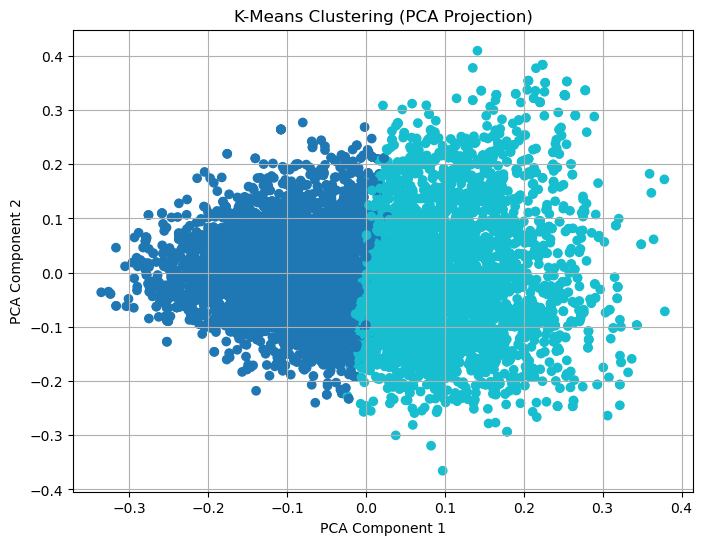

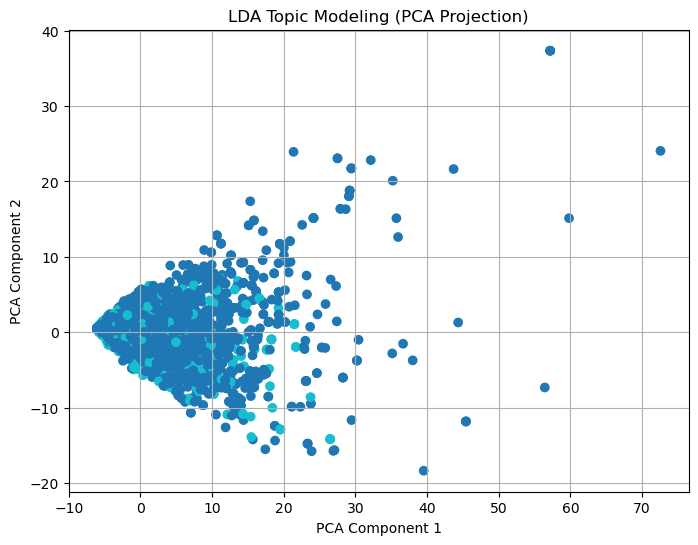

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reuse PCA on TF-IDF and count matrix
X_pca_kmeans = PCA(n_components=2).fit_transform(X_cluster.toarray())
X_pca_lda = PCA(n_components=2).fit_transform(X_count.toarray())

# K-Means Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_kmeans[:, 0], X_pca_kmeans[:, 1], c=df['cluster'], cmap='tab10')
plt.title("K-Means Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# LDA Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_lda[:, 0], X_pca_lda[:, 1], c=df['lda_topic'], cmap='tab10')
plt.title("LDA Topic Modeling (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()